In [1]:
import pandas as pd
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
from scipy.stats import ttest_rel
from sklearn.metrics import f1_score
from tqdm import tqdm
import seaborn as sns
from matplotlib.patches import Patch

# Plotting overall performance

In [5]:
settings = ['Qwen3-4B NL', 'DeepSeek-R1-Distill-Qwen-14B NL', 'DeepSeek-R1-0528-671B (API) NL', 'Llama-3.3-70B NL', 'Qwen3-4B DSPy-CoT W2', 
            'Llama-3.3-70B-Instruct DSPy-CoT W2', 'Qwen3-4B DSPy CoT FULL W1', 'Qwen3-4B DSPy CoT FULL W1', 'Qwen3-4B DSPy CoT LIGHT W1']
data = {
    'Model_Setting': settings,
    'FS_F1': [0.69, 0.66,0.72,0.76,0.72,0.71,0.73,0.73,0.73],
    'UND_F1': [0.72,0.70,0.71,0.64,0.68,0.69,0.73,0.73,0.74],
    'Accuracy': [0.71,0.68,0.71,0.71,0.70,0.7,0.73,0.73,0.73]
}

df = pd.DataFrame(data)
print("Data preview:")
print(df)

df_sorted = df.sort_values('Accuracy', ascending=True)
print("\nOrdered by UND_F1 ascending:")
print(df_sorted)

Data preview:
                        Model_Setting  FS_F1  UND_F1  Accuracy
0                         Qwen3-4B NL   0.69    0.72      0.71
1     DeepSeek-R1-Distill-Qwen-14B NL   0.66    0.70      0.68
2      DeepSeek-R1-0528-671B (API) NL   0.72    0.71      0.71
3                    Llama-3.3-70B NL   0.76    0.64      0.71
4                Qwen3-4B DSPy-CoT W2   0.72    0.68      0.70
5  Llama-3.3-70B-Instruct DSPy-CoT W2   0.71    0.69      0.70
6           Qwen3-4B DSPy CoT FULL W1   0.73    0.73      0.73
7           Qwen3-4B DSPy CoT FULL W1   0.73    0.73      0.73
8          Qwen3-4B DSPy CoT LIGHT W1   0.73    0.74      0.73

Ordered by UND_F1 ascending:
                        Model_Setting  FS_F1  UND_F1  Accuracy
1     DeepSeek-R1-Distill-Qwen-14B NL   0.66    0.70      0.68
4                Qwen3-4B DSPy-CoT W2   0.72    0.68      0.70
5  Llama-3.3-70B-Instruct DSPy-CoT W2   0.71    0.69      0.70
0                         Qwen3-4B NL   0.69    0.72      0.71
2      Deep

In [6]:
# 更新settings列表为排序后的顺序
sorted_settings = df_sorted['Model_Setting'].tolist()

# 创建图表
fig, ax = plt.subplots(figsize=(15, 12))

# 设置条形图的位置和宽度
x = np.arange(len(sorted_settings))  # 模型位置
width = 0.25  # 条形宽度

# 绘制三组条形图
bars1 = ax.bar(x - width, df_sorted['Accuracy'], width, label='Accuracy',
               color='#2E86AB', alpha=0.8, edgecolor='white', linewidth=1)
bars2 = ax.bar(x, df_sorted['FS_F1'], width, label='FS F1',
               color='#A23B72', alpha=0.8, edgecolor='white', linewidth=1)
bars3 = ax.bar(x + width, df_sorted['UND_F1'], width, label='UND F1',
               color='#F18F01', alpha=0.8, edgecolor='white', linewidth=1)

# 在这里添加虚线和注释
max_acc = df_sorted['Accuracy'].max()
ax.axhline(max_acc, linestyle='--', color='#2E86AB', linewidth=1.5, alpha=0.8)
ax.annotate(f'The Highest Accuracy: {max_acc:.2f}',
            xy=(0, max_acc),
            xytext=(-0.7, max_acc),         # x=0 表示最左边，y=max_acc 表示在水平线上
            textcoords='data',           # 表示 xytext 是真实数据坐标
            ha='left', va='bottom',      # 左对齐，下对齐（文字在这条线上方）
            fontsize=10, fontweight='bold', color='#2E86AB')

# 添加背景色以区分 cluster
no_theory_end = 5  # 前四个是 no_theory（索引0~3）
in_context_start = 6
in_context_end = len(sorted_settings) - 1

ax.axvspan(-0.5, no_theory_end + 0.5, facecolor='#B3D9FF', alpha=0.5)
ax.axvspan(in_context_start - 0.5, in_context_end + 0.5, facecolor='#FFD9B3', alpha=0.5)

# 添加图表标签和标题
ax.set_xlabel('Model Settings', fontsize=14, fontweight='bold')
ax.set_ylabel('Score', fontsize=14, fontweight='bold')
ax.set_title('Performance Comparison between Untuned Model Settings and Taxonomy-Tuned Settings on Qwen3-4B',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(sorted_settings, rotation=45, ha='right')

# 添加 legend，包括背景 cluster 的图例
metric_handles, metric_labels = ax.get_legend_handles_labels()
cluster_handles = [
    Patch(facecolor='#B3D9FF', alpha=0.3, label='No Tuning (background)'),
    Patch(facecolor='#FFD9B3', alpha=0.3, label='Taxonomy Tuning (background)')
]
ax.legend(handles=metric_handles + cluster_handles, loc='upper left', fontsize=12)

# 设置y轴范围和网格
ax.set_ylim(0.5, 0.8)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# 添加数值标签
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=9, fontweight='bold')

add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)

# 调整布局
plt.tight_layout()
plt.savefig('performance_comparison.png',
            dpi=300, bbox_inches='tight')

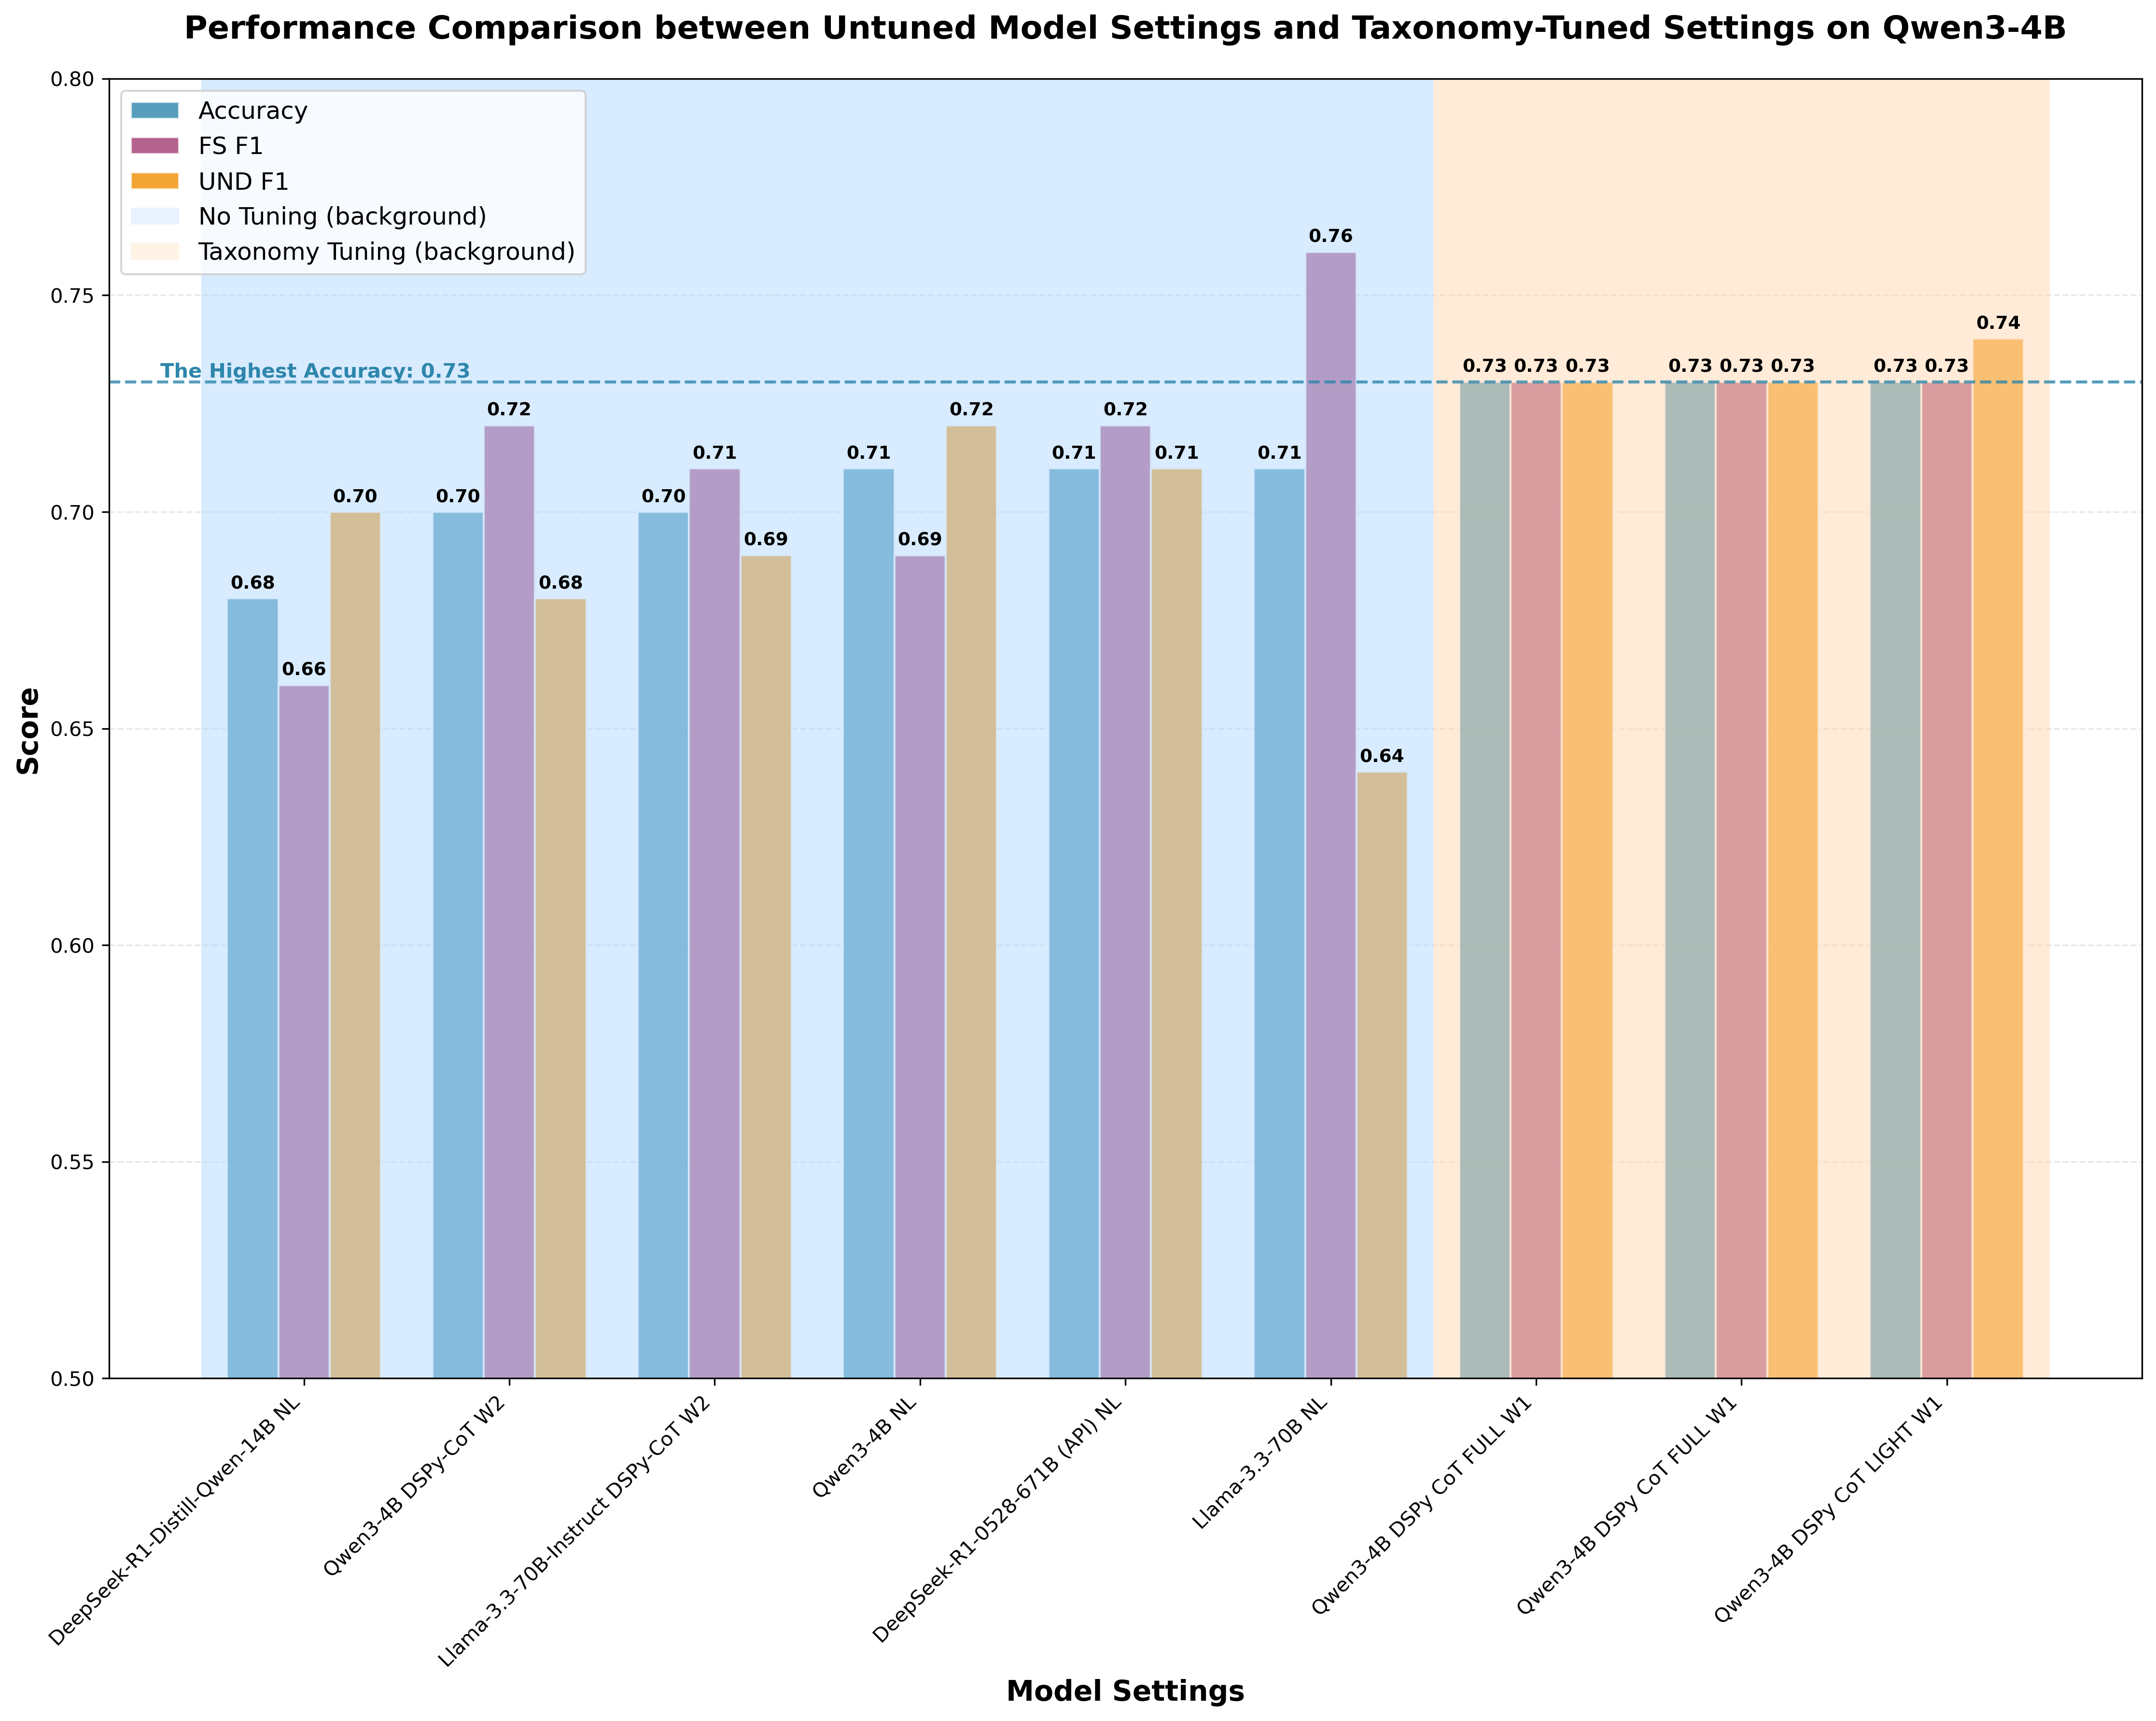

In [7]:
from IPython.display import Image
Image("performance_comparison.png")

In [13]:
# 更新settings列表为排序后的顺序
sorted_settings = df_sorted['Model_Setting'].tolist()

# 创建图表
fig, ax = plt.subplots(figsize=(15, 12))

# 设置条形图的位置和宽度
x = np.arange(len(sorted_settings))  # 模型位置
width = 0.25  # 条形宽度

# 绘制三组条形图
bars1 = ax.bar(x - width, df_sorted['Accuracy'], width, label='Accuracy',
               color='#2E86AB', alpha=0.8, edgecolor='white', linewidth=1)
bars2 = ax.bar(x, df_sorted['FS_F1'], width, label='FS F1',
               color='#A23B72', alpha=0.8, edgecolor='white', linewidth=1)
bars3 = ax.bar(x + width, df_sorted['UND_F1'], width, label='UND F1',
               color='#F18F01', alpha=0.8, edgecolor='white', linewidth=1)

# 添加红色垂直虚线表示 cluster 分界线
no_theory_end = 5  # cluster 分界点在 x = 5.5
boundary_x = no_theory_end + 0.5
ax.axvline(x=boundary_x, linestyle='--', color='red', linewidth=1.5, alpha=0.9)

# 添加左右标注说明
ax.annotate("Off-the-Shelf Model Runs",
            xy=(boundary_x - 0.1, 0.79),  # 稍靠左上方
            ha='right', va='center',
            fontsize=11, fontweight='bold', color='red')

ax.annotate("Qwen3-4B Taxonomy-Involved Runs",
            xy=(boundary_x + 0.1, 0.79),  # 稍靠右上方
            ha='left', va='center',
            fontsize=11, fontweight='bold', color='red')

# 添加图表标签和标题
ax.set_xlabel('Model Settings', fontsize=14, fontweight='bold')
ax.set_ylabel('Score', fontsize=14, fontweight='bold')
ax.set_title('Performance Comparison between Untuned Model Settings and Taxonomy-Tuned Settings on Qwen3-4B',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(sorted_settings, rotation=45, ha='right')

# 添加 legend（仅指标）
ax.legend(loc='upper left', fontsize=12)

# 设置y轴范围和网格
ax.set_ylim(0.5, 0.8)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# 添加数值标签
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=9, fontweight='bold')

add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)

# 调整布局并保存图像
plt.tight_layout()
plt.savefig('performance_comparison_new.png',
            dpi=300, bbox_inches='tight')

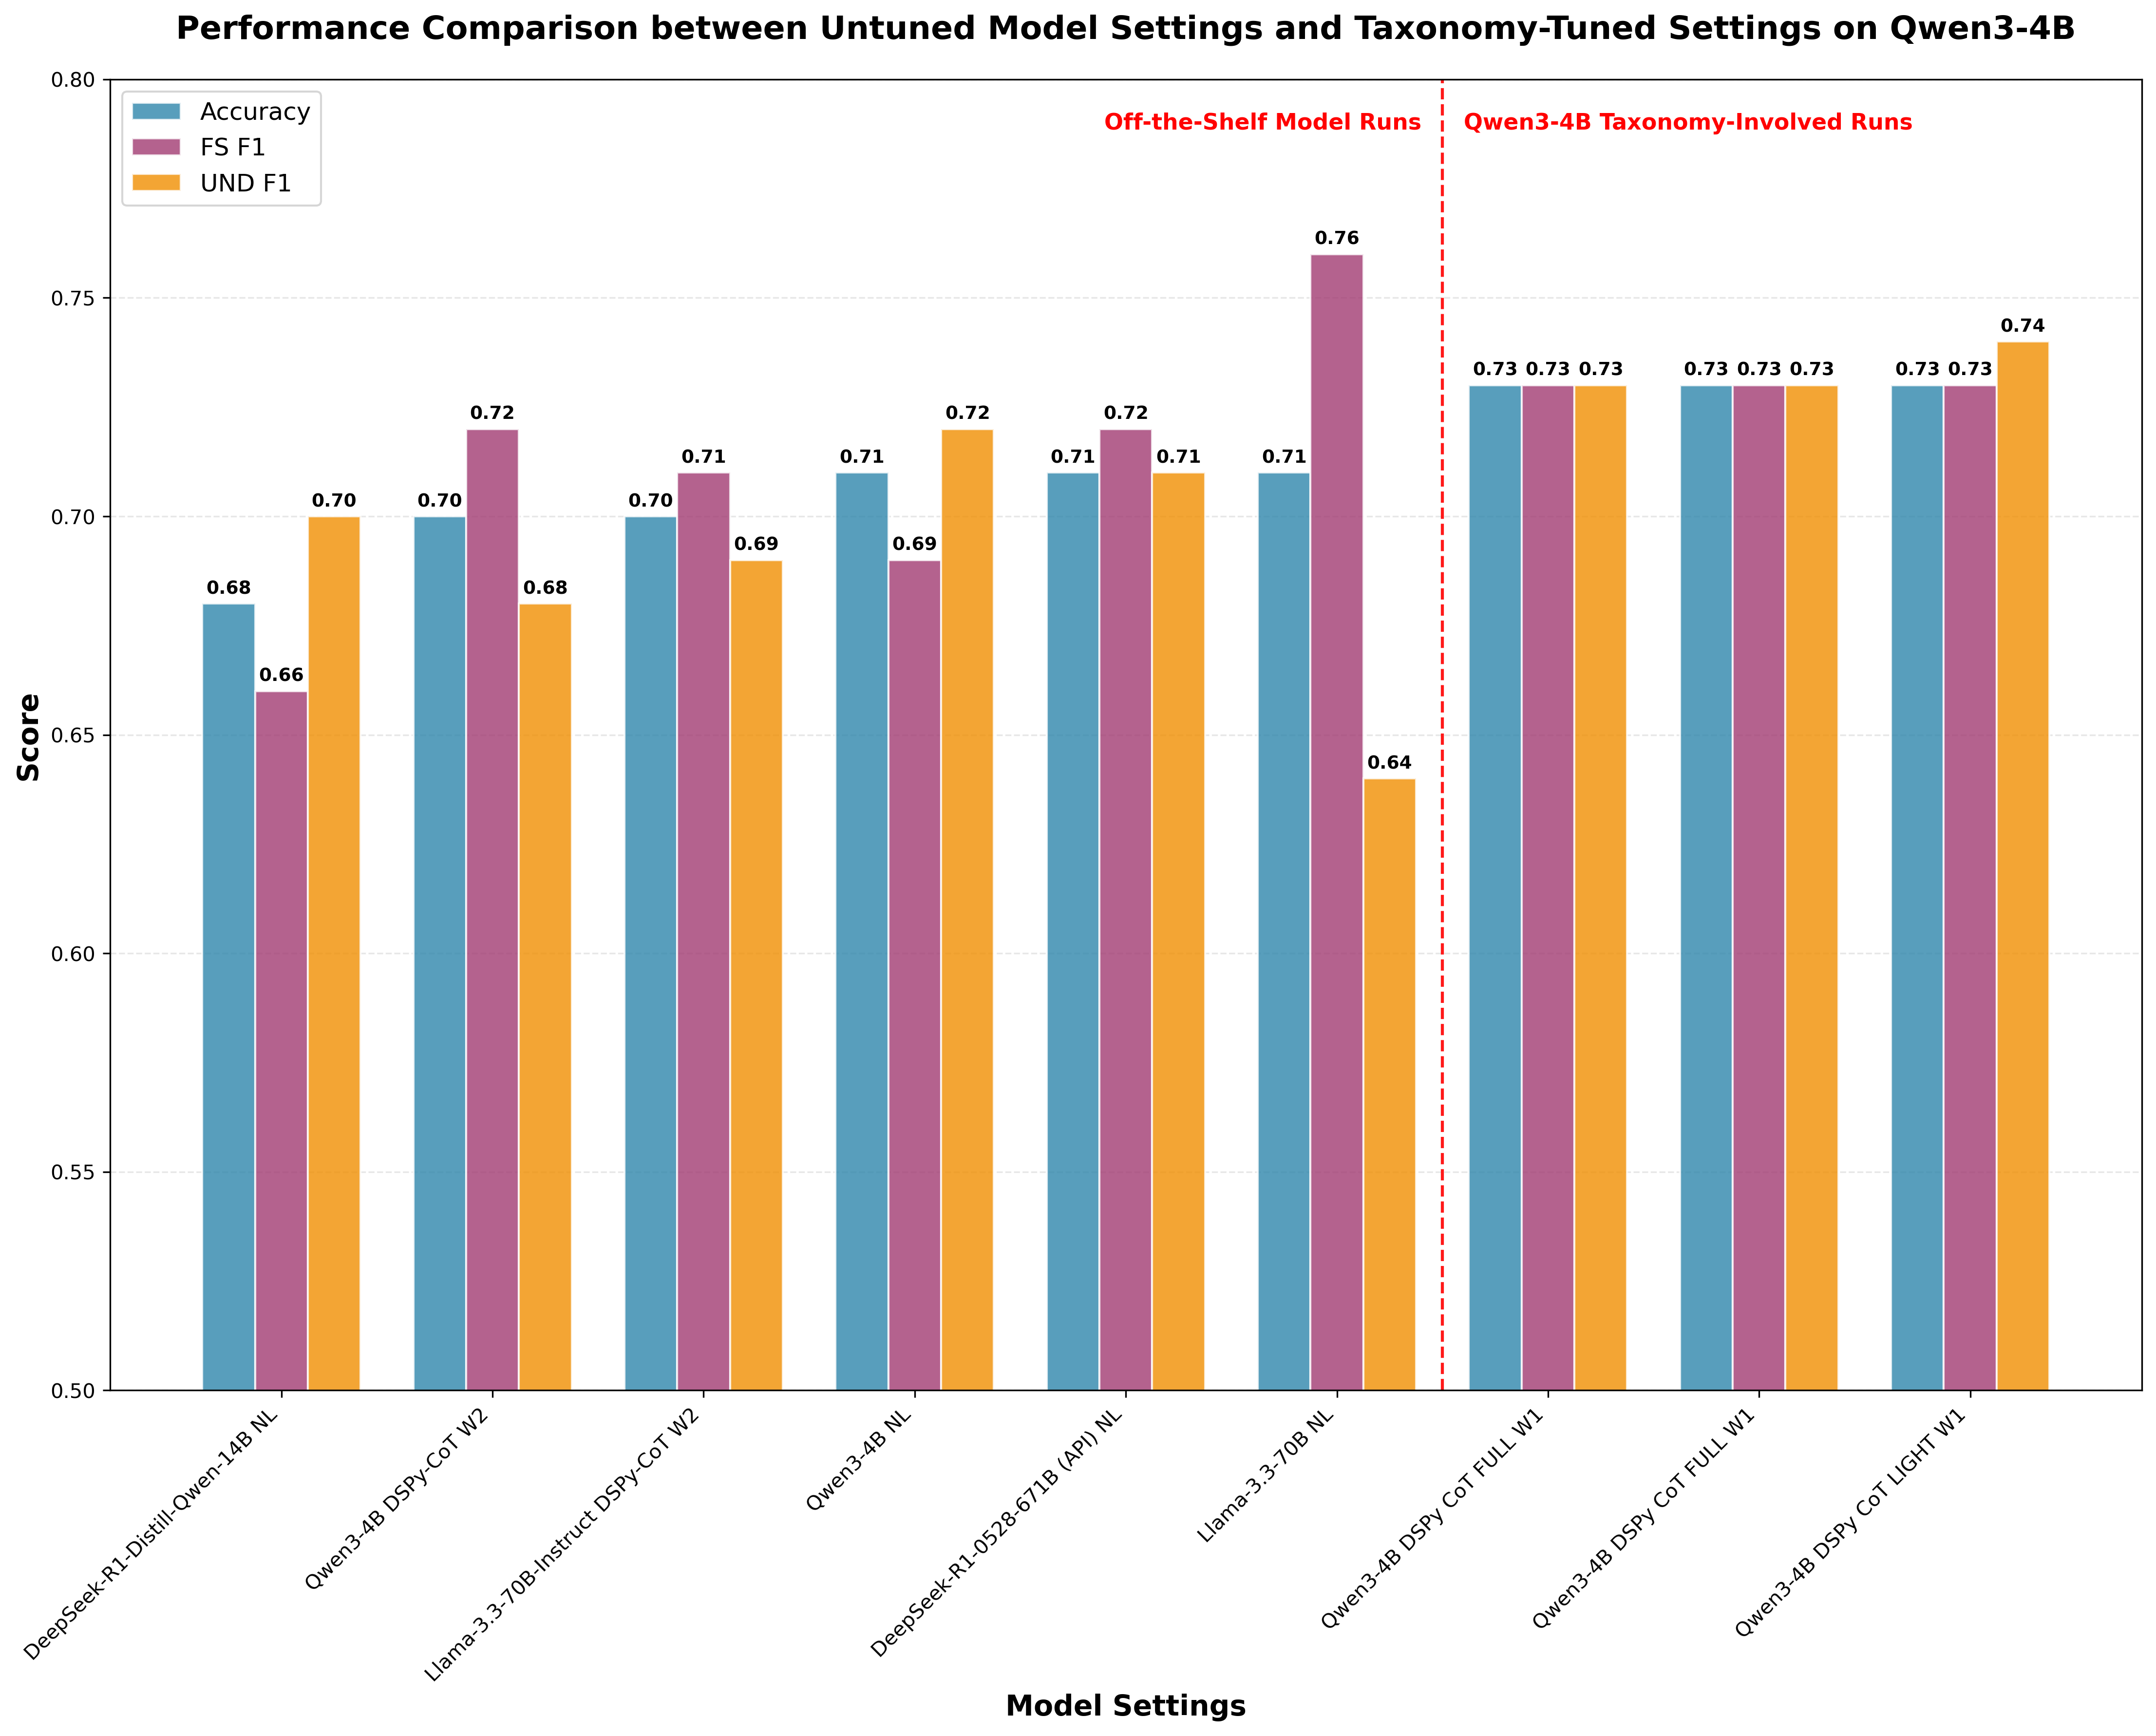

In [14]:
from IPython.display import Image
Image("performance_comparison_new.png")

## UND-QA-MS data distribution

In [6]:
labels = ['CLAMBER', 'IN3', 'AmbigNQ', 'CoCoNot']
sizes = [400, 299, 300, 156]

colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']
explode = (0, 0, 0, 0)  # 如果不想突出任何一块，可以改为 (0, 0, 0, 0)


fig, ax = plt.subplots()
ax.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    explode=explode,
    shadow=False  
)
ax.axis('equal')  
plt.title('Data Source Distribution of UND-QA-MS')
plt.savefig("data_distribution_pie.png", dpi=300)

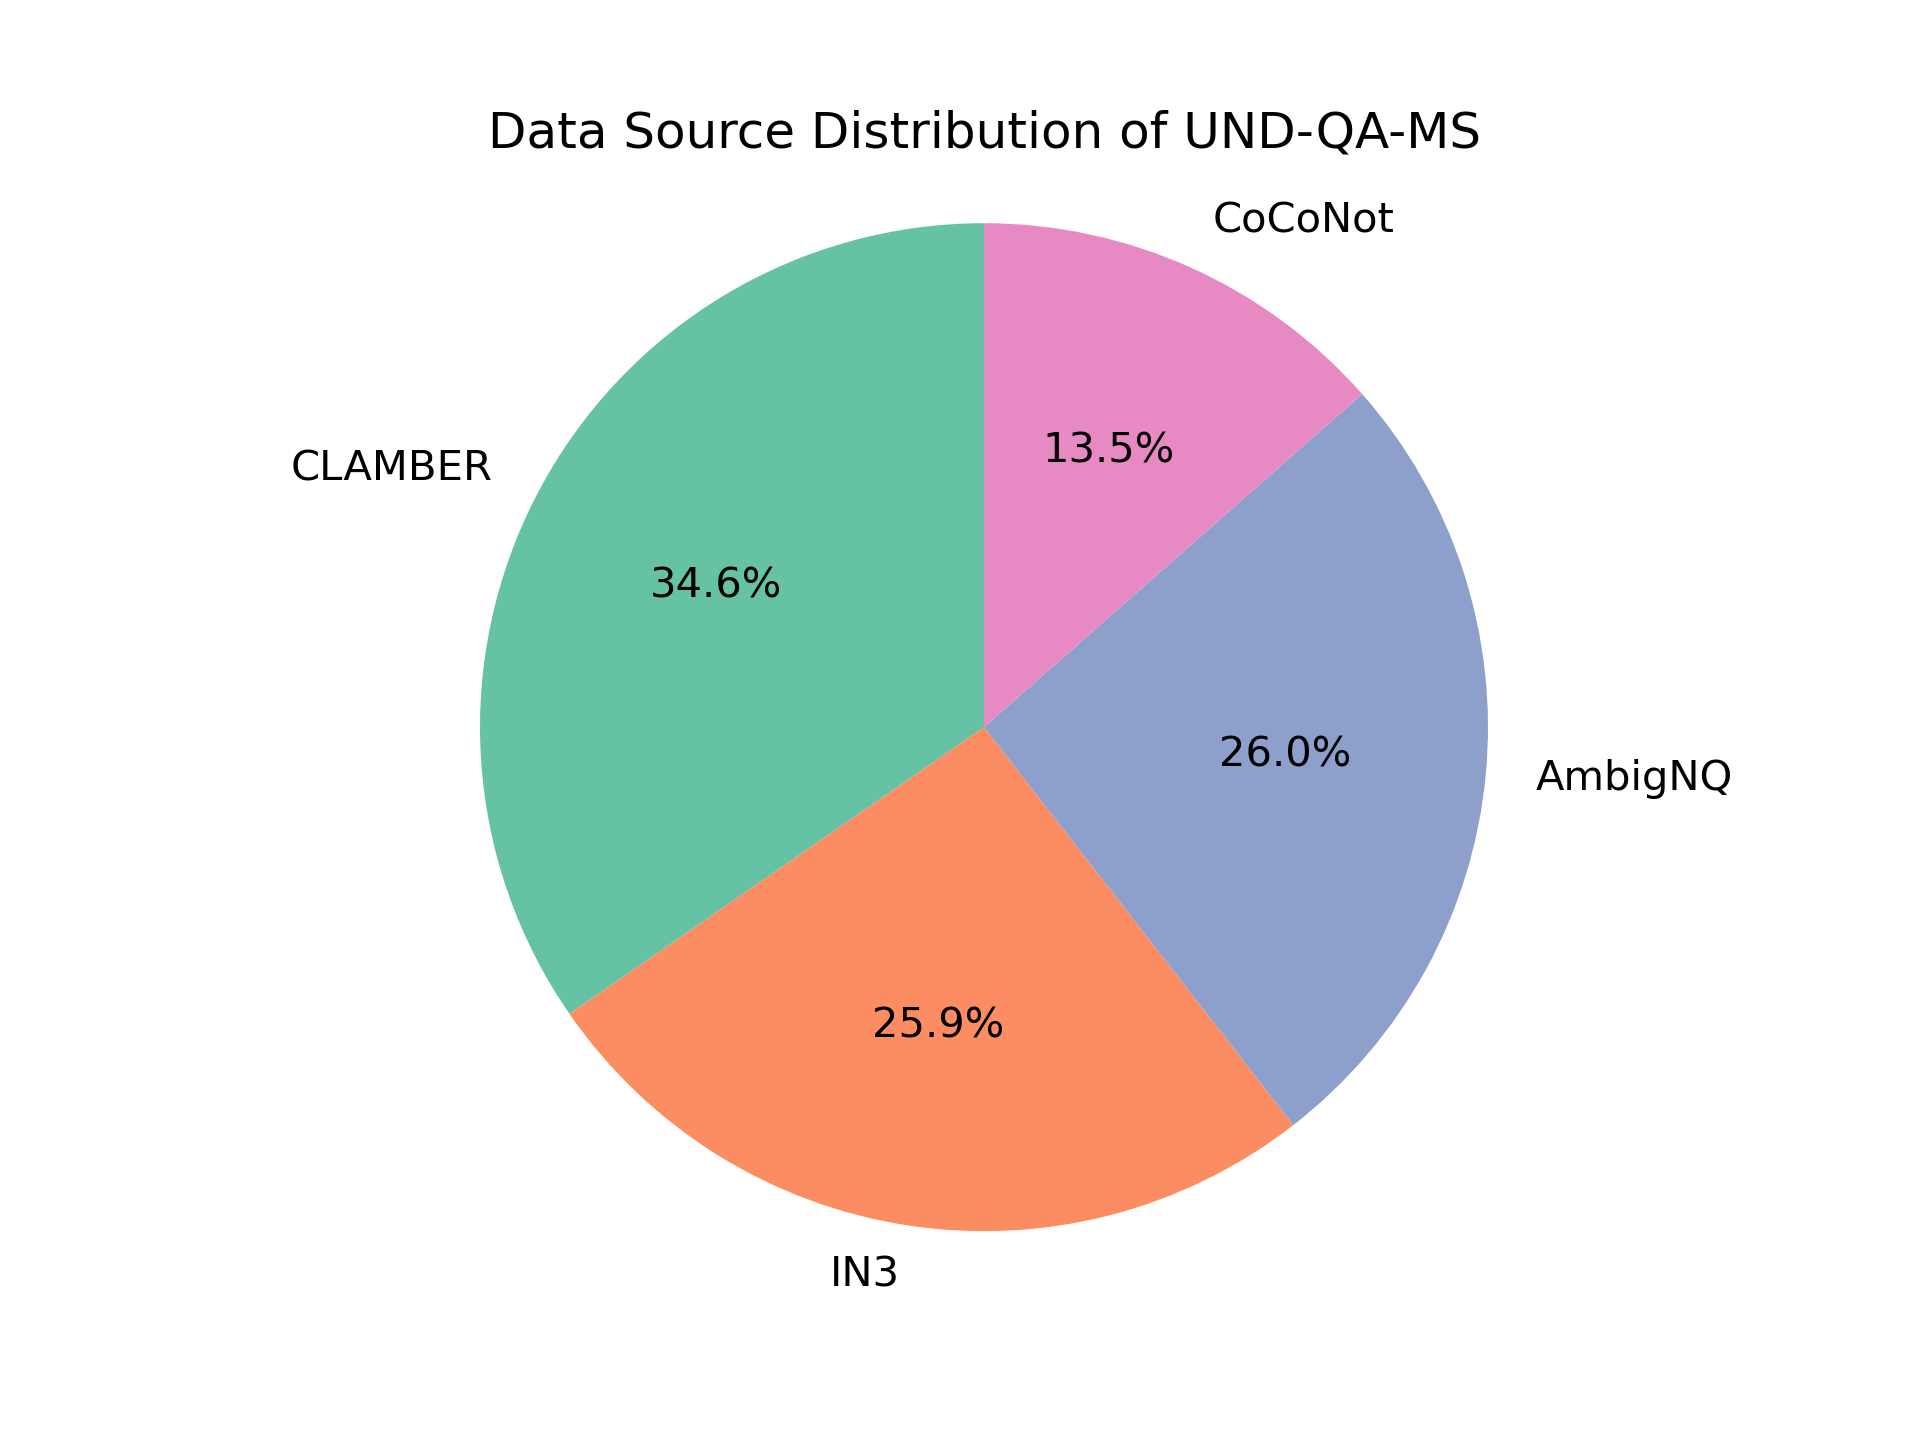

In [7]:
from IPython.display import Image
Image("data_distribution_pie.png")